# Install package

In [1]:
#pip install mplsoccer

In [2]:
#pip install adjustText

In [3]:
#pip install networkx

In [4]:
import json
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from matplotlib.colors import Normalize
from mplsoccer import Pitch, VerticalPitch, add_image
from networkx.algorithms import eigenvector_centrality
from tqdm import tqdm
from adjustText import adjust_text
from PIL import Image
from urllib.request import urlopen
import networkx as nx
import seaborn as sns
import math
from scipy.stats import vonmises

In [5]:
def read_lineup(matchid):
    return pd.read_json('https://raw.githubusercontent.com/statsbomb/open-data/master/data/lineups/'+ str(matchid) +'.json')

def read_event(matchid):
    return pd.read_json('https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/'+ str(matchid) +'.json')

def read_360(matchid):
    return pd.read_json('https://raw.githubusercontent.com/statsbomb/open-data/master/data/three-sixty/'+ str(matchid) +'.json')

def read_competition(compId, seasonId):
    return pd.read_json('https://raw.githubusercontent.com/statsbomb/open-data/master/data/matches/'+ str(compId) +'/'+ str(seasonId) +'.json')

def competition_list():
    return pd.read_json('https://raw.githubusercontent.com/statsbomb/open-data/master/data/competitions.json')

# find match_id

In [6]:
df = read_competition(11, 27) # 11: LaLiga, 27: 2015/16
len(df)

380

In [7]:
df.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,metadata,match_week,competition_stage,stadium,referee
0,3825848,2015-09-23,20:00:00.000,"{'competition_id': 11, 'country_name': 'Spain'...","{'season_id': 27, 'season_name': '2015/2016'}","{'home_team_id': 221, 'home_team_name': 'Levan...","{'away_team_id': 322, 'away_team_name': 'Eibar...",2,2,available,unscheduled,2023-02-21T15:19:45.745471,None,"{'data_version': '1.1.0', 'shot_fidelity_versi...",5,"{'id': 1, 'name': 'Regular Season'}","{'id': 350, 'name': 'Estadio Ciudad de Valenci...",NaN
1,3825895,2015-09-23,22:00:00.000,"{'competition_id': 11, 'country_name': 'Spain'...","{'season_id': 27, 'season_name': '2015/2016'}","{'home_team_id': 208, 'home_team_name': 'Las P...","{'away_team_id': 213, 'away_team_name': 'Sevil...",2,0,available,unscheduled,2023-02-21T15:19:07.927548,None,"{'data_version': '1.1.0', 'shot_fidelity_versi...",5,"{'id': 1, 'name': 'Regular Season'}","{'id': 357, 'name': 'Estadio de Gran Canaria',...","{'id': 2728, 'name': 'Carlos del Cerro Grande'..."
2,3825894,2016-05-01,18:15:00.000,"{'competition_id': 11, 'country_name': 'Spain'...","{'season_id': 27, 'season_name': '2015/2016'}","{'home_team_id': 219, 'home_team_name': 'RC De...","{'away_team_id': 216, 'away_team_name': 'Getaf...",0,2,available,unscheduled,2022-08-30T12:53:16.828350,None,"{'data_version': '1.1.0', 'shot_fidelity_versi...",36,"{'id': 1, 'name': 'Regular Season'}","{'id': 4658, 'name': 'Estadio Abanca-Riazor', ...","{'id': 1008, 'name': 'Carlos Clos Gómez', 'cou..."
3,3825855,2016-05-02,20:30:00.000,"{'competition_id': 11, 'country_name': 'Spain'...","{'season_id': 27, 'season_name': '2015/2016'}","{'home_team_id': 223, 'home_team_name': 'Málag...","{'away_team_id': 221, 'away_team_name': 'Levan...",3,1,available,unscheduled,2022-08-30T12:53:53.790835,None,"{'data_version': '1.1.0', 'shot_fidelity_versi...",36,"{'id': 1, 'name': 'Regular Season'}","{'id': 346, 'name': 'Estadio La Rosaleda', 'co...","{'id': 2480, 'name': 'Iñaki Bikandi Garrido', ..."
4,3825908,2016-05-15,19:00:00.000,"{'competition_id': 11, 'country_name': 'Spain'...","{'season_id': 27, 'season_name': '2015/2016'}","{'home_team_id': 214, 'home_team_name': 'Espan...","{'away_team_id': 322, 'away_team_name': 'Eibar...",4,2,available,unscheduled,2022-04-06T22:39:49.425989,None,"{'data_version': '1.1.0', 'shot_fidelity_versi...",38,"{'id': 1, 'name': 'Regular Season'}","{'id': 351, 'name': 'RCDE Stadium', 'country':...","{'id': 2692, 'name': 'Mario Melero López', 'co..."


In [8]:
df = df[['match_id', 'match_date', 'home_team', 'away_team', 'home_score', 'away_score', 'match_week']]
df.head()

,match_id,match_date,home_team,away_team,home_score,away_score,match_week
0,3825848,2015-09-23,"{'home_team_id': 221, 'home_team_name': 'Levan...","{'away_team_id': 322, 'away_team_name': 'Eibar...",2,2,5
1,3825895,2015-09-23,"{'home_team_id': 208, 'home_team_name': 'Las P...","{'away_team_id': 213, 'away_team_name': 'Sevil...",2,0,5
2,3825894,2016-05-01,"{'home_team_id': 219, 'home_team_name': 'RC De...","{'away_team_id': 216, 'away_team_name': 'Getaf...",0,2,36
3,3825855,2016-05-02,"{'home_team_id': 223, 'home_team_name': 'Málag...","{'away_team_id': 221, 'away_team_name': 'Levan...",3,1,36
4,3825908,2016-05-15,"{'home_team_id': 214, 'home_team_name': 'Espan...","{'away_team_id': 322, 'away_team_name': 'Eibar...",4,2,38


In [9]:
# cleaning (no need ids)
df.home_team = [x['home_team_name'] for x in df.home_team]
df.away_team = [x['away_team_name'] for x in df.away_team]

In [10]:
df[(df.home_team=='Barcelona')&(df.away_team=='Real Madrid')]

,match_id,match_date,home_team,away_team,home_score,away_score,match_week
349,267533,2016-04-02,Barcelona,Real Madrid,1,2,31


# cleaning

In [11]:
dfMatch = read_event(267533)
dfMatch.head()

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,...,dribble,clearance,duel,out,bad_behaviour,shot,goalkeeper,ball_recovery,block,substitution
0,aa442c8f-59f2-4081-be40-f75ba64f98b9,1,1,2024-02-25,0,0,"{'id': 35, 'name': 'Starting XI'}",1,"{'id': 217, 'name': 'Barcelona'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,46520499-bd35-49fc-acbf-e8aafea2981d,2,1,2024-02-25,0,0,"{'id': 35, 'name': 'Starting XI'}",1,"{'id': 217, 'name': 'Barcelona'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,989f6293-d4c9-41e2-ae92-f4433a1caba6,3,1,2024-02-25,0,0,"{'id': 18, 'name': 'Half Start'}",1,"{'id': 217, 'name': 'Barcelona'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0b921647-1431-4394-ba02-815c80f5bff2,4,1,2024-02-25,0,0,"{'id': 18, 'name': 'Half Start'}",1,"{'id': 217, 'name': 'Barcelona'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00ac4828-a5ff-468f-bb4d-a52d00c66b8b,5,1,2024-02-25,0,0,"{'id': 30, 'name': 'Pass'}",2,"{'id': 217, 'name': 'Barcelona'}","{'id': 9, 'name': 'From Kick Off'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
dfLineup = read_lineup(267533)
dfLineup.head()

,team_id,team_name,lineup
0,220,Real Madrid,"[{'player_id': 3063, 'player_name': 'Danilo Lu..."
1,217,Barcelona,"[{'player_id': 4320, 'player_name': 'Neymar da..."


In [13]:
dfLineupBarca = pd.DataFrame(dfLineup.iloc[1].lineup)
dfLineupBarca

,player_id,player_name,player_nickname,jersey_number,country,cards,positions
0,4320,Neymar da Silva Santos Junior,Neymar,11,"{'id': 31, 'name': 'Brazil'}",[],"[{'position_id': 21, 'position': 'Left Wing', ..."
1,4324,Daniel Alves da Silva,Dani Alves,6,"{'id': 31, 'name': 'Brazil'}",[],"[{'position_id': 2, 'position': 'Right Back', ..."
2,4691,Claudio Andrés Bravo Muñoz,Claudio Bravo,13,"{'id': 45, 'name': 'Chile'}",[],"[{'position_id': 1, 'position': 'Goalkeeper', ..."
3,5203,Sergio Busquets i Burgos,Sergio Busquets,5,"{'id': 214, 'name': 'Spain'}",[],"[{'position_id': 10, 'position': 'Center Defen..."
4,5211,Jordi Alba Ramos,Jordi Alba,18,"{'id': 214, 'name': 'Spain'}",[],"[{'position_id': 6, 'position': 'Left Back', '..."
5,5213,Gerard Piqué Bernabéu,Gerard Piqué,3,"{'id': 214, 'name': 'Spain'}",[],"[{'position_id': 3, 'position': 'Right Center ..."
6,5216,Andrés Iniesta Luján,Andrés Iniesta,8,"{'id': 214, 'name': 'Spain'}",[],"[{'position_id': 15, 'position': 'Left Center ..."
7,5246,Luis Alberto Suárez Díaz,Luis Suárez,9,"{'id': 242, 'name': 'Uruguay'}","[{'time': '26:26', 'card_type': 'Yellow Card',...","[{'position_id': 17, 'position': 'Right Wing',..."
8,5470,Ivan Rakitić,None,4,"{'id': 56, 'name': 'Croatia'}","[{'time': '57:45', 'card_type': 'Yellow Card',...","[{'position_id': 13, 'position': 'Right Center..."
9,5503,Lionel Andrés Messi Cuccittini,Lionel Messi,10,"{'id': 11, 'name': 'Argentina'}",[],"[{'position_id': 23, 'position': 'Center Forwa..."


In [14]:
dfMatch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3700 entries, 0 to 3699
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               3700 non-null   object        
 1   index            3700 non-null   int64         
 2   period           3700 non-null   int64         
 3   timestamp        3700 non-null   datetime64[ns]
 4   minute           3700 non-null   int64         
 5   second           3700 non-null   int64         
 6   type             3700 non-null   object        
 7   possession       3700 non-null   int64         
 8   possession_team  3700 non-null   object        
 9   play_pattern     3700 non-null   object        
 10  team             3700 non-null   object        
 11  duration         2667 non-null   float64       
 12  tactics          3 non-null      object        
 13  related_events   3573 non-null   object        
 14  player           3689 non-null   object 

In [15]:
# cleaning (simplify structure)
dfMatch.type = [x['name'] for x in dfMatch.type]
dfMatch.play_pattern = [x['name'] for x in dfMatch.play_pattern]
dfMatch.possession_team = [x['name'] for x in dfMatch.possession_team]
dfMatch.team = [x['name'] for x in dfMatch.team]
dfMatch.head()

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,...,dribble,clearance,duel,out,bad_behaviour,shot,goalkeeper,ball_recovery,block,substitution
0,aa442c8f-59f2-4081-be40-f75ba64f98b9,1,1,2024-02-25,0,0,Starting XI,1,Barcelona,Regular Play,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,46520499-bd35-49fc-acbf-e8aafea2981d,2,1,2024-02-25,0,0,Starting XI,1,Barcelona,Regular Play,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,989f6293-d4c9-41e2-ae92-f4433a1caba6,3,1,2024-02-25,0,0,Half Start,1,Barcelona,Regular Play,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0b921647-1431-4394-ba02-815c80f5bff2,4,1,2024-02-25,0,0,Half Start,1,Barcelona,Regular Play,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00ac4828-a5ff-468f-bb4d-a52d00c66b8b,5,1,2024-02-25,0,0,Pass,2,Barcelona,From Kick Off,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# check type of events
Counter(dfMatch.type)

Counter({'Pass': 1062,
         'Ball Receipt*': 1033,
         'Carry': 897,
         'Pressure': 240,
         'Ball Recovery': 86,
         'Duel': 45,
         'Foul Committed': 44,
         'Foul Won': 42,
         'Goal Keeper': 31,
         'Block': 30,
         'Dribble': 29,
         'Shot': 29,
         'Miscontrol': 23,
         'Clearance': 23,
         'Dispossessed': 23,
         'Dribbled Past': 19,
         'Interception': 17,
         'Injury Stoppage': 7,
         'Half Start': 4,
         'Half End': 4,
         'Substitution': 3,
         'Starting XI': 2,
         'Bad Behaviour': 2,
         'Error': 2,
         'Player Off': 1,
         'Player On': 1,
         'Tactical Shift': 1})

In [17]:
# see passes only
dfPass = dfMatch[dfMatch.type=='Pass']
dfPass.head()

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,...,dribble,clearance,duel,out,bad_behaviour,shot,goalkeeper,ball_recovery,block,substitution
4,00ac4828-a5ff-468f-bb4d-a52d00c66b8b,5,1,2024-02-25 00:00:00,0,0,Pass,2,Barcelona,From Kick Off,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,faa20878-d360-4a5e-8609-1a63760b0f14,8,1,2024-02-25 00:00:00,0,0,Pass,2,Barcelona,From Kick Off,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,cd262c4e-f14e-43ce-92f2-5300315d501c,11,1,2024-02-25 00:00:03,0,3,Pass,2,Barcelona,From Kick Off,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,682d1d32-813e-496b-82c4-c5379d0056f9,14,1,2024-02-25 00:00:05,0,5,Pass,2,Barcelona,From Kick Off,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,b6b27152-5e72-4157-a67b-aa2acd51c852,17,1,2024-02-25 00:00:12,0,12,Pass,2,Barcelona,From Kick Off,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# cleaning (remove NA columns)
dfPass.dropna(axis='columns',how='all',inplace=True)
dfPass.head()

C:\Users\Alvis Cheung\AppData\Local\Temp\ipykernel_11004\119193510.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfPass.dropna(axis='columns',how='all',inplace=True)


,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,team,duration,related_events,player,position,location,pass,under_pressure,off_camera,counterpress
4,00ac4828-a5ff-468f-bb4d-a52d00c66b8b,5,1,2024-02-25 00:00:00,0,0,Pass,2,Barcelona,From Kick Off,Barcelona,0.227900,[b93c3bed-f3b4-4abd-bfcc-c59622140fe8],"{'id': 5246, 'name': 'Luis Alberto Suárez Díaz'}","{'id': 17, 'name': 'Right Wing'}","[60.0, 40.0]","{'recipient': {'id': 5503, 'name': 'Lionel And...",NaN,NaN,NaN
7,faa20878-d360-4a5e-8609-1a63760b0f14,8,1,2024-02-25 00:00:00,0,0,Pass,2,Barcelona,From Kick Off,Barcelona,1.363343,[20aca2bd-cac3-4c57-bd4f-3e2b0fd6fcc0],"{'id': 5503, 'name': 'Lionel Andrés Messi Cucc...","{'id': 23, 'name': 'Center Forward'}","[59.8, 42.4]","{'recipient': {'id': 5203, 'name': 'Sergio Bus...",NaN,NaN,NaN
10,cd262c4e-f14e-43ce-92f2-5300315d501c,11,1,2024-02-25 00:00:03,0,3,Pass,2,Barcelona,From Kick Off,Barcelona,1.397122,[bcfeb78c-ca24-41d9-937a-022b9d231c71],"{'id': 5203, 'name': 'Sergio Busquets i Burgos'}","{'id': 10, 'name': 'Center Defensive Midfield'}","[48.0, 33.8]","{'recipient': {'id': 5506, 'name': 'Javier Ale...",NaN,NaN,NaN
13,682d1d32-813e-496b-82c4-c5379d0056f9,14,1,2024-02-25 00:00:05,0,5,Pass,2,Barcelona,From Kick Off,Barcelona,1.216400,[5484fca1-b209-444b-9620-000477f83a50],"{'id': 5506, 'name': 'Javier Alejandro Mascher...","{'id': 5, 'name': 'Left Center Back'}","[35.8, 27.5]","{'recipient': {'id': 5213, 'name': 'Gerard Piq...",NaN,NaN,NaN
16,b6b27152-5e72-4157-a67b-aa2acd51c852,17,1,2024-02-25 00:00:12,0,12,Pass,2,Barcelona,From Kick Off,Barcelona,1.312500,[58d15305-7c18-4f54-b9e2-6da5aecdec6f],"{'id': 5213, 'name': 'Gerard Piqué Bernabéu'}","{'id': 3, 'name': 'Right Center Back'}","[49.1, 52.9]","{'recipient': {'id': 5470, 'name': 'Ivan Rakit...",NaN,NaN,NaN


In [19]:
# cleaning (simplify structure)
dfPass.player = [x['name'] for x in dfPass.player]

C:\Users\Alvis Cheung\AppData\Local\Temp\ipykernel_11004\2480353846.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfPass.player = [x['name'] for x in dfPass.player]


In [20]:
dfPass.related_events[:10]

4                [b93c3bed-f3b4-4abd-bfcc-c59622140fe8]
7                [20aca2bd-cac3-4c57-bd4f-3e2b0fd6fcc0]
10               [bcfeb78c-ca24-41d9-937a-022b9d231c71]
13               [5484fca1-b209-444b-9620-000477f83a50]
16               [58d15305-7c18-4f54-b9e2-6da5aecdec6f]
19               [c4988461-ab37-4684-9206-5034e8cdd6ec]
22               [f124dc15-3beb-411c-89ef-4975dbef302a]
26    [15c2394f-ab56-4148-863b-dd87381dda13, 68a1e5e...
29               [27b43849-74b3-457b-8a74-6f3b05c8c209]
32               [67583657-dc59-4bc1-94cb-8bdd0394c59e]
Name: related_events, dtype: object

In [21]:
# extract related_event's type
dfPass['related_events_type'] = [[dfMatch[dfMatch.id==eventId].type.iloc[0] for eventId in x] if type(x) is list else [] for x in dfPass.related_events]
dfPass.head()

C:\Users\Alvis Cheung\AppData\Local\Temp\ipykernel_11004\2598046361.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfPass['related_events_type'] = [[dfMatch[dfMatch.id==eventId].type.iloc[0] for eventId in x] if type(x) is list else [] for x in dfPass.related_events]


,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,...,duration,related_events,player,position,location,pass,under_pressure,off_camera,counterpress,related_events_type
4,00ac4828-a5ff-468f-bb4d-a52d00c66b8b,5,1,2024-02-25 00:00:00,0,0,Pass,2,Barcelona,From Kick Off,...,0.227900,[b93c3bed-f3b4-4abd-bfcc-c59622140fe8],Luis Alberto Suárez Díaz,"{'id': 17, 'name': 'Right Wing'}","[60.0, 40.0]","{'recipient': {'id': 5503, 'name': 'Lionel And...",NaN,NaN,NaN,[Ball Receipt*]
7,faa20878-d360-4a5e-8609-1a63760b0f14,8,1,2024-02-25 00:00:00,0,0,Pass,2,Barcelona,From Kick Off,...,1.363343,[20aca2bd-cac3-4c57-bd4f-3e2b0fd6fcc0],Lionel Andrés Messi Cuccittini,"{'id': 23, 'name': 'Center Forward'}","[59.8, 42.4]","{'recipient': {'id': 5203, 'name': 'Sergio Bus...",NaN,NaN,NaN,[Ball Receipt*]
10,cd262c4e-f14e-43ce-92f2-5300315d501c,11,1,2024-02-25 00:00:03,0,3,Pass,2,Barcelona,From Kick Off,...,1.397122,[bcfeb78c-ca24-41d9-937a-022b9d231c71],Sergio Busquets i Burgos,"{'id': 10, 'name': 'Center Defensive Midfield'}","[48.0, 33.8]","{'recipient': {'id': 5506, 'name': 'Javier Ale...",NaN,NaN,NaN,[Ball Receipt*]
13,682d1d32-813e-496b-82c4-c5379d0056f9,14,1,2024-02-25 00:00:05,0,5,Pass,2,Barcelona,From Kick Off,...,1.216400,[5484fca1-b209-444b-9620-000477f83a50],Javier Alejandro Mascherano,"{'id': 5, 'name': 'Left Center Back'}","[35.8, 27.5]","{'recipient': {'id': 5213, 'name': 'Gerard Piq...",NaN,NaN,NaN,[Ball Receipt*]
16,b6b27152-5e72-4157-a67b-aa2acd51c852,17,1,2024-02-25 00:00:12,0,12,Pass,2,Barcelona,From Kick Off,...,1.312500,[58d15305-7c18-4f54-b9e2-6da5aecdec6f],Gerard Piqué Bernabéu,"{'id': 3, 'name': 'Right Center Back'}","[49.1, 52.9]","{'recipient': {'id': 5470, 'name': 'Ivan Rakit...",NaN,NaN,NaN,[Ball Receipt*]


# extract pass subfields

In [22]:
dfPass.head()

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,...,duration,related_events,player,position,location,pass,under_pressure,off_camera,counterpress,related_events_type
4,00ac4828-a5ff-468f-bb4d-a52d00c66b8b,5,1,2024-02-25 00:00:00,0,0,Pass,2,Barcelona,From Kick Off,...,0.227900,[b93c3bed-f3b4-4abd-bfcc-c59622140fe8],Luis Alberto Suárez Díaz,"{'id': 17, 'name': 'Right Wing'}","[60.0, 40.0]","{'recipient': {'id': 5503, 'name': 'Lionel And...",NaN,NaN,NaN,[Ball Receipt*]
7,faa20878-d360-4a5e-8609-1a63760b0f14,8,1,2024-02-25 00:00:00,0,0,Pass,2,Barcelona,From Kick Off,...,1.363343,[20aca2bd-cac3-4c57-bd4f-3e2b0fd6fcc0],Lionel Andrés Messi Cuccittini,"{'id': 23, 'name': 'Center Forward'}","[59.8, 42.4]","{'recipient': {'id': 5203, 'name': 'Sergio Bus...",NaN,NaN,NaN,[Ball Receipt*]
10,cd262c4e-f14e-43ce-92f2-5300315d501c,11,1,2024-02-25 00:00:03,0,3,Pass,2,Barcelona,From Kick Off,...,1.397122,[bcfeb78c-ca24-41d9-937a-022b9d231c71],Sergio Busquets i Burgos,"{'id': 10, 'name': 'Center Defensive Midfield'}","[48.0, 33.8]","{'recipient': {'id': 5506, 'name': 'Javier Ale...",NaN,NaN,NaN,[Ball Receipt*]
13,682d1d32-813e-496b-82c4-c5379d0056f9,14,1,2024-02-25 00:00:05,0,5,Pass,2,Barcelona,From Kick Off,...,1.216400,[5484fca1-b209-444b-9620-000477f83a50],Javier Alejandro Mascherano,"{'id': 5, 'name': 'Left Center Back'}","[35.8, 27.5]","{'recipient': {'id': 5213, 'name': 'Gerard Piq...",NaN,NaN,NaN,[Ball Receipt*]
16,b6b27152-5e72-4157-a67b-aa2acd51c852,17,1,2024-02-25 00:00:12,0,12,Pass,2,Barcelona,From Kick Off,...,1.312500,[58d15305-7c18-4f54-b9e2-6da5aecdec6f],Gerard Piqué Bernabéu,"{'id': 3, 'name': 'Right Center Back'}","[49.1, 52.9]","{'recipient': {'id': 5470, 'name': 'Ivan Rakit...",NaN,NaN,NaN,[Ball Receipt*]


In [23]:
# get all the keys of the dict
pass_col = []
for x in dfPass['pass']:
    pass_col.extend(list(x.keys()))
    pass_col = list(set(pass_col))
pass_col

['assisted_shot_id',
 'aerial_won',
 'shot_assist',
 'outcome',
 'body_part',
 'inswinging',
 'length',
 'miscommunication',
 'through_ball',
 'height',
 'no_touch',
 'technique',
 'outswinging',
 'cross',
 'deflected',
 'end_location',
 'type',
 'angle',
 'recipient',
 'cut_back',
 'goal_assist',
 'switch']

In [24]:
# create new col for each sub-field
pd.options.mode.chained_assignment = None
for i in pass_col:
    if i in dfPass.columns: name = 'pass_'+i
    else: name = i
    dfPass[name] = [ x[i] if i in x.keys() else None for x in dfPass['pass'] ]
dfPass.head()

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,...,outswinging,cross,deflected,end_location,pass_type,angle,recipient,cut_back,goal_assist,switch
4,00ac4828-a5ff-468f-bb4d-a52d00c66b8b,5,1,2024-02-25 00:00:00,0,0,Pass,2,Barcelona,From Kick Off,...,None,None,None,"[59.8, 42.4]","{'id': 65, 'name': 'Kick Off'}",1.653938,"{'id': 5503, 'name': 'Lionel Andrés Messi Cucc...",None,None,None
7,faa20878-d360-4a5e-8609-1a63760b0f14,8,1,2024-02-25 00:00:00,0,0,Pass,2,Barcelona,From Kick Off,...,None,None,None,"[48.4, 40.7]",None,-2.993561,"{'id': 5203, 'name': 'Sergio Busquets i Burgos'}",None,None,None
10,cd262c4e-f14e-43ce-92f2-5300315d501c,11,1,2024-02-25 00:00:03,0,3,Pass,2,Barcelona,From Kick Off,...,None,None,None,"[36.3, 27.5]",None,-2.647651,"{'id': 5506, 'name': 'Javier Alejandro Mascher...",None,None,None
13,682d1d32-813e-496b-82c4-c5379d0056f9,14,1,2024-02-25 00:00:05,0,5,Pass,2,Barcelona,From Kick Off,...,None,None,None,"[35.2, 46.6]",None,1.602200,"{'id': 5213, 'name': 'Gerard Piqué Bernabéu'}",None,None,None
16,b6b27152-5e72-4157-a67b-aa2acd51c852,17,1,2024-02-25 00:00:12,0,12,Pass,2,Barcelona,From Kick Off,...,None,None,None,"[58.1, 57.7]",None,0.489957,"{'id': 5470, 'name': 'Ivan Rakitić'}",None,None,None


In [25]:
# check if need further extract
dict_col = [i for i in pass_col
            if type([x for x in dfPass[i] if x!=None][0]) is dict]
dict_col

['outcome', 'body_part', 'height', 'technique', 'recipient']

In [26]:
for i in dict_col:
    print([x for x in dfPass[i] if x!=None][:5])

[{'id': 9, 'name': 'Incomplete'}, {'id': 9, 'name': 'Incomplete'}, {'id': 76, 'name': 'Pass Offside'}, {'id': 76, 'name': 'Pass Offside'}, {'id': 9, 'name': 'Incomplete'}]
[{'id': 40, 'name': 'Right Foot'}, {'id': 40, 'name': 'Right Foot'}, {'id': 40, 'name': 'Right Foot'}, {'id': 38, 'name': 'Left Foot'}, {'id': 40, 'name': 'Right Foot'}]
[{'id': 1, 'name': 'Ground Pass'}, {'id': 1, 'name': 'Ground Pass'}, {'id': 1, 'name': 'Ground Pass'}, {'id': 1, 'name': 'Ground Pass'}, {'id': 1, 'name': 'Ground Pass'}]
[{'id': 108, 'name': 'Through Ball'}, {'id': 108, 'name': 'Through Ball'}, {'id': 108, 'name': 'Through Ball'}, {'id': 108, 'name': 'Through Ball'}, {'id': 105, 'name': 'Outswinging'}]
[{'id': 5503, 'name': 'Lionel Andrés Messi Cuccittini'}, {'id': 5203, 'name': 'Sergio Busquets i Burgos'}, {'id': 5506, 'name': 'Javier Alejandro Mascherano'}, {'id': 5213, 'name': 'Gerard Piqué Bernabéu'}, {'id': 5470, 'name': 'Ivan Rakitić'}]


In [27]:
# extract just the name field
for i in dict_col:
    dfPass[i] = [x['name'] if x!=None else None for x in dfPass[i]]
dfPass.head()

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,...,outswinging,cross,deflected,end_location,pass_type,angle,recipient,cut_back,goal_assist,switch
4,00ac4828-a5ff-468f-bb4d-a52d00c66b8b,5,1,2024-02-25 00:00:00,0,0,Pass,2,Barcelona,From Kick Off,...,None,None,None,"[59.8, 42.4]","{'id': 65, 'name': 'Kick Off'}",1.653938,Lionel Andrés Messi Cuccittini,None,None,None
7,faa20878-d360-4a5e-8609-1a63760b0f14,8,1,2024-02-25 00:00:00,0,0,Pass,2,Barcelona,From Kick Off,...,None,None,None,"[48.4, 40.7]",None,-2.993561,Sergio Busquets i Burgos,None,None,None
10,cd262c4e-f14e-43ce-92f2-5300315d501c,11,1,2024-02-25 00:00:03,0,3,Pass,2,Barcelona,From Kick Off,...,None,None,None,"[36.3, 27.5]",None,-2.647651,Javier Alejandro Mascherano,None,None,None
13,682d1d32-813e-496b-82c4-c5379d0056f9,14,1,2024-02-25 00:00:05,0,5,Pass,2,Barcelona,From Kick Off,...,None,None,None,"[35.2, 46.6]",None,1.602200,Gerard Piqué Bernabéu,None,None,None
16,b6b27152-5e72-4157-a67b-aa2acd51c852,17,1,2024-02-25 00:00:12,0,12,Pass,2,Barcelona,From Kick Off,...,None,None,None,"[58.1, 57.7]",None,0.489957,Ivan Rakitić,None,None,None


In [28]:
dfPass[dfPass.columns[-20:]].head()

,shot_assist,outcome,body_part,inswinging,length,miscommunication,through_ball,height,no_touch,technique,outswinging,cross,deflected,end_location,pass_type,angle,recipient,cut_back,goal_assist,switch
4,None,None,Right Foot,None,2.408319,None,None,Ground Pass,None,None,None,None,None,"[59.8, 42.4]","{'id': 65, 'name': 'Kick Off'}",1.653938,Lionel Andrés Messi Cuccittini,None,None,None
7,None,None,Right Foot,None,11.526057,None,None,Ground Pass,None,None,None,None,None,"[48.4, 40.7]",None,-2.993561,Sergio Busquets i Burgos,None,None,None
10,None,None,Right Foot,None,13.288341,None,None,Ground Pass,None,None,None,None,None,"[36.3, 27.5]",None,-2.647651,Javier Alejandro Mascherano,None,None,None
13,None,None,Left Foot,None,19.109423,None,None,Ground Pass,None,None,None,None,None,"[35.2, 46.6]",None,1.602200,Gerard Piqué Bernabéu,None,None,None
16,None,None,Right Foot,None,10.200000,None,None,Ground Pass,None,None,None,None,None,"[58.1, 57.7]",None,0.489957,Ivan Rakitić,None,None,None


In [29]:
Counter(dfPass.technique), Counter(dfPass.height), Counter(dfPass.switch)

(Counter({None: 1048, 'Through Ball': 9, 'Outswinging': 4, 'Inswinging': 1}),
 Counter({'Ground Pass': 761, 'High Pass': 168, 'Low Pass': 133}),
 Counter({None: 1043, True: 19}))

# plot individual's passes

source: https://soccermatics.readthedocs.io/en/latest/gallery/lesson1/plot_PlottingPasses.html

blue: completed

red: incompleted

green: assist

In [30]:
def plotPass(full_name, short_name):
    #drawing pitch
    pitch = Pitch(line_color = "grey")
    fig, ax = pitch.draw(figsize=(10, 7))

    incomplete = [x[1].location + x[1].end_location for x in dfPass[dfPass.player==full_name].iterrows() if x[1].outcome in ["Incomplete", "Pass Offside"] ]
    assist =     [x[1].location + x[1].end_location for x in dfPass[dfPass.player==full_name].iterrows() if ((x[1].outcome not in ["Incomplete", "Pass Offside"]) & (x[1].goal_assist is True)) ]
    complete =   [x[1].location + x[1].end_location for x in dfPass[dfPass.player==full_name].iterrows() if ((x[1].outcome not in ["Incomplete", "Pass Offside"]) & (x[1].goal_assist is not True)) ]

    pitch.arrows([x[0] for x in complete], [x[1] for x in complete],
                 [x[2] for x in complete], [x[3] for x in complete],
                 width=2, color="blue", ax=ax)
    pitch.arrows([x[0] for x in incomplete], [x[1] for x in incomplete],
                 [x[2] for x in incomplete], [x[3] for x in incomplete],
                 width=2, color="red", ax=ax)
    pitch.arrows([x[0] for x in assist], [x[1] for x in assist],
                 [x[2] for x in assist], [x[3] for x in assist],
                 width=2, color="green", ax=ax)


    ax.plot(0,0,c='b',label='Completed',linewidth=2)
    ax.plot(0,0,c='r',label='Failed',linewidth=2)
    ax.plot(0,0,c='g',label='Assist',linewidth=2)
    ax.legend(bbox_to_anchor=(0.07,0.8), fontsize=12)

    ax.set_title(short_name + "'s passes\nin 2015/16 LaLiga matchday 31 El Clasico", fontsize = 24)
    fig.set_size_inches(10, 7)
    plt.show()

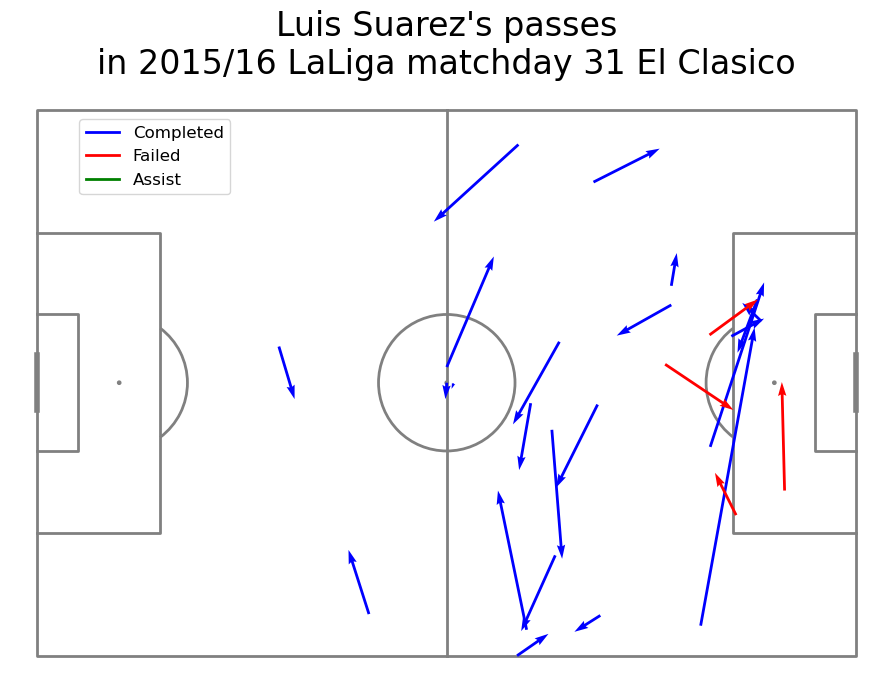

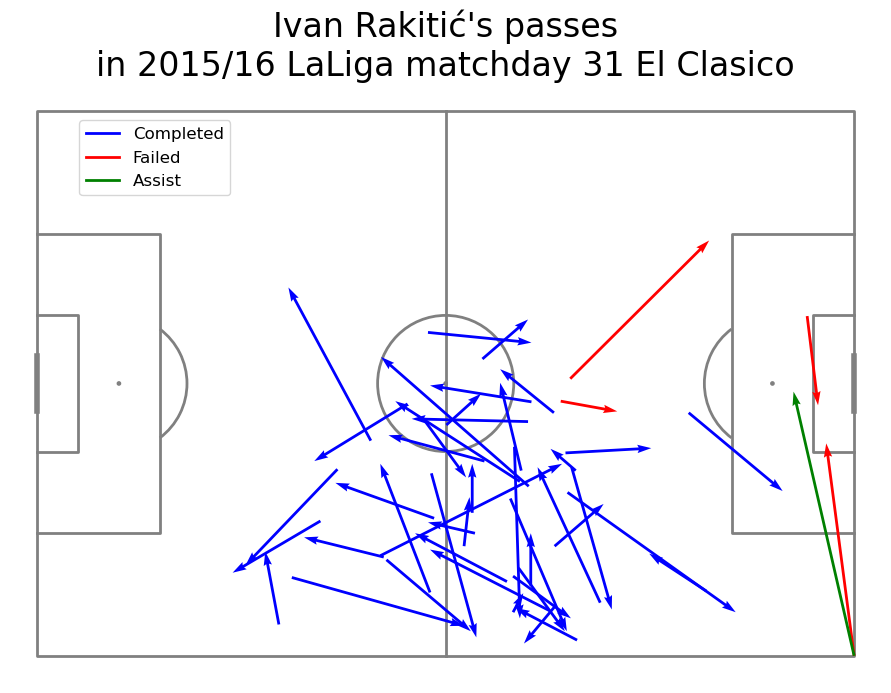

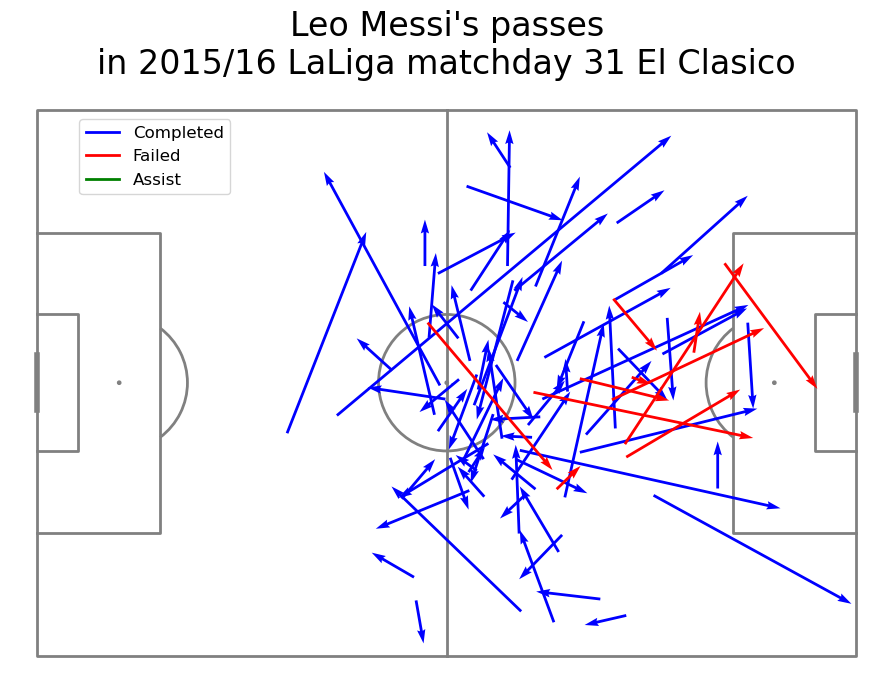

In [31]:
plotPass('Luis Alberto Suárez Díaz','Luis Suarez')
plotPass('Ivan Rakitić','Ivan Rakitić')
plotPass('Lionel Andrés Messi Cuccittini','Leo Messi')

Comparing the passes of Suarez and Rakitic, we can see Suarez's passes were more horizontal while Rakitic's were more vertical.

# plot pass maps

In [32]:
[x['card'] for x in dfMatch[dfMatch.type=='Foul Committed'].dropna(axis=1,how='all').foul_committed if isinstance(x, dict) if 'card' in x.keys()]

[{'id': 7, 'name': 'Yellow Card'},
 {'id': 7, 'name': 'Yellow Card'},
 {'id': 7, 'name': 'Yellow Card'},
 {'id': 7, 'name': 'Yellow Card'},
 {'id': 6, 'name': 'Second Yellow'}]

In [33]:
tmp = dfLineup.copy()
team = tmp.team_name
team

0    Real Madrid
1      Barcelona
Name: team_name, dtype: object

In [34]:
pd.options.mode.chained_assignment = None
dfMinutes = pd.DataFrame(columns=['player_name','player_nickname','from','to','minutes'])

# get each team's lineup
tmp = dfLineup.copy()
team = tmp.team_name
tmp0 = pd.DataFrame(tmp.iloc[0].lineup)
tmp1 = pd.DataFrame(tmp.iloc[1].lineup)
del tmp

x = []

for tmp,t in zip([tmp0, tmp1], team):

    # only use players who have played
    tmp['from'] = [x[0]['from'] if x!=[] else None for x in tmp.positions]
    tmp['to'] = [x[0]['to'] if x!=[] else None for x in tmp.positions]
    tmp = tmp[np.invert((tmp['from'].isnull())&(tmp['to'].isnull()))]

    # find total game time (90 + injury time)
    minutes = dfMatch.copy()
    minutes = minutes[minutes.type=='Half End'].iloc[-1].minute + round(minutes[minutes.type=='Half End'].iloc[-1].second/60)

    # get 'from' and 'to' minute
    tmp['from'] = [ np.min([int(i['from'].split(':')[0]) + round(int(i['from'].split(':')[1])/60) for i in x])
                if x!=[] else None
                for x in tmp.positions]
    tmp['to'] = [ np.max([int(i['to'].split(':')[0]) + round(int(i['to'].split(':')[1])/60) if i['to'] is not None else minutes for i in x])
                if x!=[] else None
                for x,y in zip(tmp.positions, tmp.cards)]
    
    # sent offs (if player is sent off, he is still present in the lineup table)
    tmp['to'] = [b if b is not None else a for a,b in zip(tmp['to'],
    [None if z is None else (None if z==[] else int(z[0].split(':')[0]) + round(int(z[0].split(':')[1])/60))
    for z in[[i['time'] for i in y if i['card_type'] in ['Second Yellow','Red Card']] if y!=[] else None for y in tmp.cards]]
    )]

    # calculate player minutes
    tmp['minutes'] = [y-x if (pd.notna(x) & pd.notna(y)) else None for x,y in zip(tmp['from'],tmp['to'])]

    # get position abbre
    tmp['pos'] = [x[0]['position_id'] for x in tmp.positions]
    tmp['positions'] = [ ('').join([s[0] for s in x[0]['position'].split(' ')]) for x in tmp.positions]
    tmp.replace({'positions':'G'},'GK',inplace=True)

    # get player nickname
    tmp['player_nickname'].fillna(tmp['player_name'],inplace=True)

    # formatting
    tmp = tmp[['player_name','player_nickname','pos','positions','from','to','minutes']]
    tmp.sort_values(by=['from','pos'],inplace=True)
    tmp.reset_index(drop=True,inplace=True)
    tmp['team'] = t

    x.append(tmp)

x

[                            player_name    player_nickname  pos positions  \
 0                   Keylor Navas Gamboa       Keylor Navas    1        GK   
 1                 Daniel Carvajal Ramos    Daniel Carvajal    2        RB   
 2          Kléper Laveran Lima Ferreira               Pepe    3       RCB   
 3                   Sergio Ramos García       Sergio Ramos    5       LCB   
 4        Marcelo Vieira da Silva Júnior            Marcelo    6        LB   
 5              Carlos Henrique Casimiro           Casemiro   10       CDM   
 6                           Luka Modrić        Luka Modrić   13       RCM   
 7                            Toni Kroos         Toni Kroos   15       LCM   
 8                     Gareth Frank Bale        Gareth Bale   17        RW   
 9   Cristiano Ronaldo dos Santos Aveiro  Cristiano Ronaldo   21        LW   
 10                        Karim Benzema      Karim Benzema   23        CF   
 11                  Jesé Rodríguez Ruiz               Jesé   23

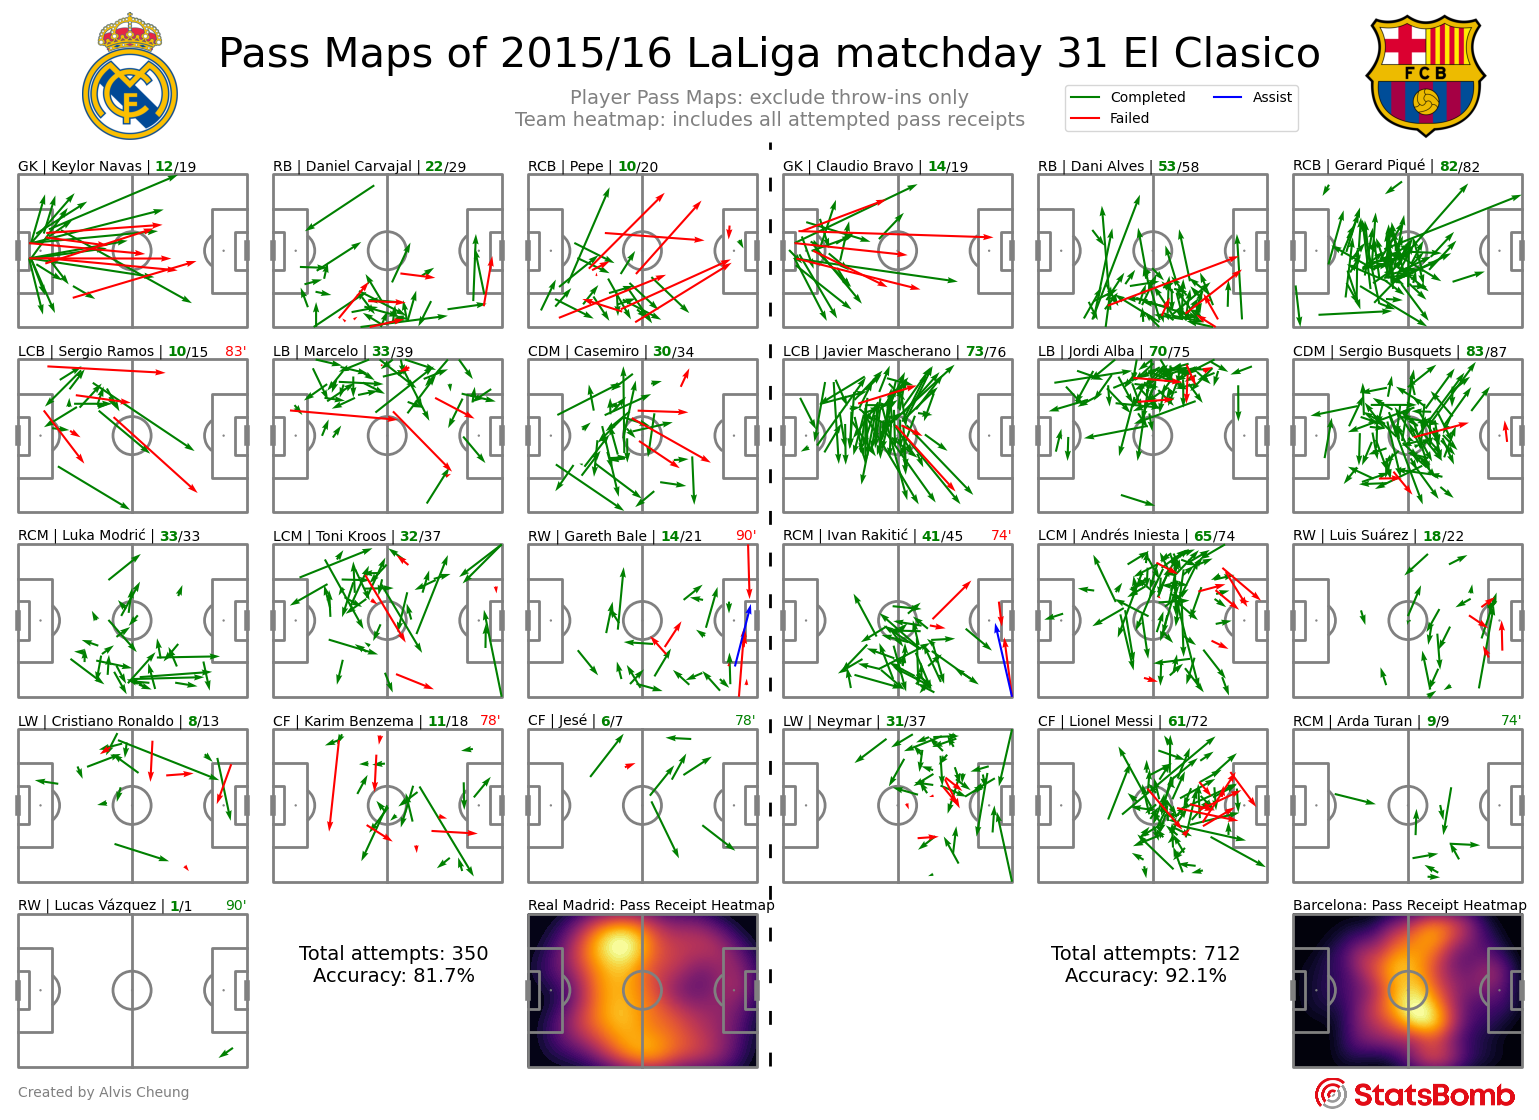

In [35]:
nrows = (len(x[0])+len(x[1]))//6 + 1
subtitlefont = 10

#drawing pitch
pitch = Pitch(line_color = "grey")
fig, axs = pitch.grid(nrows=nrows, ncols=6, figheight=8,
                      endnote_height=0.03, endnote_space=0,
                      title_height=0.12, title_space=0.02,
                      axis=False,
                      grid_height=0.83)

# tracker variables
teamA = True
plotted = [0,0]
offset = 0

for idx, ax in enumerate(axs['pitch'].flat):

    # switch to team A if ax is the 1st of the row
    if idx%6==0:
            teamA = True
    else:
    # switch to team B if ax is the 4th of the row
            if idx%3==0:
                teamA = False

    tmp = x[0] if teamA else x[1]
    offset -= (3 if ((idx%3==0) & (idx%6!=0)) else 0) # offset value for the ax index matching to the correct player
    

    if idx < len(x[0])+len(x[1]) :
    
            if (plotted[0] if teamA else plotted[1]) < len(tmp):

                # prepare the passes data
                incomplete = [x[1].location + x[1].end_location for x in dfPass[dfPass.player==tmp.iloc[idx + offset].player_name].iterrows() if x[1].outcome in ["Incomplete", "Pass Offside"] ]
                assist =     [x[1].location + x[1].end_location for x in dfPass[dfPass.player==tmp.iloc[idx + offset].player_name].iterrows() if ((x[1].outcome not in ["Incomplete", "Pass Offside"]) & (x[1].goal_assist is True)) ]
                complete =   [x[1].location + x[1].end_location for x in dfPass[dfPass.player==tmp.iloc[idx + offset].player_name].iterrows() if ((x[1].outcome not in ["Incomplete", "Pass Offside"]) & (x[1].goal_assist is not True)) ]

                # plot the passes
                pitch.arrows([x[0] for x in complete], [x[1] for x in complete],
                                [x[2] for x in complete], [x[3] for x in complete],
                                width=1.5, color="green", ax=ax)
                pitch.arrows([x[0] for x in incomplete], [x[1] for x in incomplete],
                                [x[2] for x in incomplete], [x[3] for x in incomplete],
                                width=1.5, color="red", ax=ax)
                pitch.arrows([x[0] for x in assist], [x[1] for x in assist],
                                [x[2] for x in assist], [x[3] for x in assist],
                                width=1.5, color="blue", ax=ax)

                
                ax.plot(0,0,c='g',label='Completed',linewidth=1.5)
                ax.plot(0,0,c='r',label='Failed',linewidth=1.5)
                ax.plot(0,0,c='b',label='Assist',linewidth=1.5)

                #ax.legend(bbox_to_anchor=(0.07,0.8), fontsize=12)
                #ax.set_title(tmp.iloc[idx].player_nickname + "'s passes\nin 2015/16 LaLiga matchday 31 El Clasico", fontsize = 10)

                # prepare title for each subplot
                text0 = tmp.iloc[idx + offset].positions + ' | ' + tmp.iloc[idx + offset].player_nickname + ' | '
                text1 = str(len(complete)+len(assist)-len(incomplete))
                text2 = '/' + str(len(complete)+len(assist))

                # plot the title, and the on/off time
                t = ax.text(0,-2, text0 , fontsize = subtitlefont, ha = 'left')
                t = ax.annotate(text1, xycoords = t, xy=(1, 0), ha='left', va='bottom', color="g", weight="bold")
                t = ax.annotate(text2, xycoords = t, xy=(1, 0), ha='left', va='bottom')
                if tmp.iloc[idx + offset]['from'] != 0: 
                    t = ax.text(120,-2, str(tmp.iloc[idx + offset]['from'])+"'" , fontsize = subtitlefont, ha = 'right', color='g')
                if tmp.iloc[idx + offset]['to'] != np.max(tmp['to']): 
                    t = ax.text(120,-2, str(tmp.iloc[idx + offset]['to'])+"'" , fontsize = subtitlefont, ha = 'right', color='r')

    else:
        # if ax is on the last row
        if idx//6+1 == nrows:
            if (idx+1)%3 == 0:
                # if ax is the 3rd of the row, then plot team A
                if (idx+1)%6 == 3:
                    mapTeam = tmp.team[0]
                # if ax is the 6th of the row, then plot team B
                elif (idx+1)%6 == 0:
                        mapTeam = tmp.team[1]
                
                # prepare data for passes receipt
                mapX = [a[0] for a in dfMatch[(dfMatch.type=='Ball Receipt*') & (dfMatch.team==mapTeam)].dropna(axis=1,how='all').location]
                mapY = [a[1] for a in dfMatch[(dfMatch.type=='Ball Receipt*') & (dfMatch.team==mapTeam)].dropna(axis=1,how='all').location]

                # plot the heat map
                pitch.kdeplot(x=mapX, y=mapY, ax=ax,
                            cmap='inferno',
                            levels=100, 
                            thresh=0, fill=True,
                            zorder=0.5)
                ax.text(0,-2, mapTeam+': Pass Receipt Heatmap' , fontsize = subtitlefont, ha = 'left')
                

            # remove pitch if no plot on it
            else: ax.remove()
        else: ax.remove()

# logos
madrid_logo = Image.open(urlopen('https://upload.wikimedia.org/wikipedia/en/thumb/5/56/Real_Madrid_CF.svg/800px-Real_Madrid_CF.svg.png'))
barca_logo = Image.open(urlopen('https://upload.wikimedia.org/wikipedia/en/thumb/4/47/FC_Barcelona_%28crest%29.svg/1024px-FC_Barcelona_%28crest%29.svg.png'))
sb_logo = Image.open(urlopen('https://raw.githubusercontent.com/statsbomb/open-data/master/img/SB%20-%20Icon%20Lockup%20-%20Colour%20positive.png'))

ax_madrid_logo = add_image(madrid_logo, fig,
                            left=0.07,
                            bottom=axs['title'].get_position().y0,
                            height=axs['title'].get_position().height)
ax_barca_logo = add_image(barca_logo, fig,
                          left=axs['title'].get_position().width-0.07,
                          bottom=axs['title'].get_position().y0,
                          height=axs['title'].get_position().height)
ax_sb_logo = add_image(sb_logo, fig,
                       left=axs['endnote'].get_position().width-0.1,
                       bottom=axs['endnote'].get_position().y0,
                       height=axs['endnote'].get_position().height)

# texts
axs['title'].text(0.5,0.65,"Pass Maps of 2015/16 LaLiga matchday 31 El Clasico", fontsize=30, va='center',ha='center')
SUB_TEXT = ('Player Pass Maps: exclude throw-ins only\n'
            'Team heatmap: includes all attempted pass receipts')
axs['title'].text(0.5,0.25,SUB_TEXT, fontsize=14, va='center',ha='center', c='grey')
axs['endnote'].text(0, 0.5, 'Created by Alvis Cheung',
                    fontsize=subtitlefont, c='grey', va='center', ha='left')

## get the number of complete and total passes
madrid_complete = len([x for x in dfPass[dfPass.team==x[0].team[0]].iterrows() if x[1].outcome not in ["Incomplete", "Pass Offside"] ])
madrid_total = len(dfPass[dfPass.team==x[0].team[0]])
barca_complete = len([x for x in dfPass[dfPass.team==x[1].team[0]].iterrows() if x[1].outcome not in ["Incomplete", "Pass Offside"] ])
barca_total = len(dfPass[dfPass.team==x[1].team[0]])

# texts
madrid_text = 'Total attempts: '+str(madrid_total)+'\nAccuracy: '+'{:.1%}'.format(madrid_complete/madrid_total)
barca_text = 'Total attempts: '+str(barca_total)+'\nAccuracy: '+'{:.1%}'.format(barca_complete/barca_total)
axs['endnote'].text(0.25,5, madrid_text,
                    va='top',ha='center', fontsize=14)
axs['endnote'].text(0.75,5, barca_text,
                    va='top',ha='center', fontsize=14)


# legend
axs['pitch'].flat[0].legend(bbox_to_anchor=(4.8,1.35),loc='center',ncols=2)

# line to separate the 2 teams
fig.add_artist(lines.Line2D([0.5,0.5], [0.04,0.88], color='k', linestyle=(0,(5,10)), lw=2))

fig.set_size_inches(16,11)
plt.show()

# plot pass angles and lengths

In [36]:
dfPass[dfPass.team=="Barcelona"][['location','end_location','length','angle']].head()


,location,end_location,length,angle
4,"[60.0, 40.0]","[59.8, 42.4]",2.408319,1.653938
7,"[59.8, 42.4]","[48.4, 40.7]",11.526057,-2.993561
10,"[48.0, 33.8]","[36.3, 27.5]",13.288341,-2.647651
13,"[35.8, 27.5]","[35.2, 46.6]",19.109423,1.602200
16,"[49.1, 52.9]","[58.1, 57.7]",10.200000,0.489957


In [37]:
tmp = dfPass[['team','location','end_location','length','angle']].copy()
tmp['location_m'] = [[x[0]/120*105,x[1]/80*68] for x in tmp.location]
tmp['end_location_m'] = [[x[0]/120*105,x[1]/80*68] for x in tmp.end_location]
tmp['length_m'] = [np.linalg.norm(np.array(x)-np.array(y)) for x,y in zip(tmp.location_m, tmp.end_location_m)]
tmp['angle_m'] = [math.atan2(y[1]-x[1], y[0]-x[0])/math.pi*180 for x,y in zip(tmp.location_m, tmp.end_location_m)]
tmp.head()

,team,location,end_location,length,angle,location_m,end_location_m,length_m,angle_m
4,Barcelona,"[60.0, 40.0]","[59.8, 42.4]",2.408319,1.653938,"[52.5, 34.0]","[52.324999999999996, 36.04]",2.047492,94.903075
7,Barcelona,"[59.8, 42.4]","[48.4, 40.7]",11.526057,-2.993561,"[52.324999999999996, 36.04]","[42.35, 34.595]",10.079120,-171.757348
10,Barcelona,"[48.0, 33.8]","[36.3, 27.5]",13.288341,-2.647651,"[42.0, 28.73]","[31.7625, 23.375]",11.553460,-152.386972
13,Barcelona,"[35.8, 27.5]","[35.2, 46.6]",19.109423,1.602200,"[31.324999999999996, 23.375]","[30.8, 39.61]",16.243486,91.852159
16,Barcelona,"[49.1, 52.9]","[58.1, 57.7]",10.200000,0.489957,"[42.9625, 44.965]","[50.837500000000006, 49.045]",8.869161,27.388459


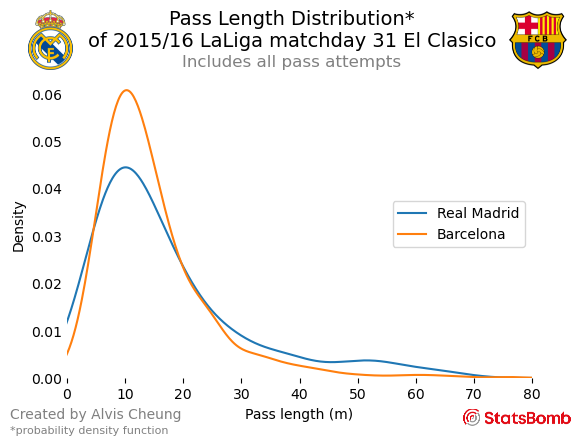

In [38]:
n_bin = np.linspace(0,120,24+1)

# plot
fig = plt.figure(figsize=(6,4))
ax = tmp[tmp.team=="Real Madrid"].length_m.plot(kind='density')
tmp[tmp.team=="Barcelona"].length_m.plot(kind='density')
# ax = tmp[tmp.team=="Real Madrid"].length_m.hist(alpha=0.5,density=True,bins=n_bin)
# tmp[tmp.team=="Barcelona"].length_m.hist(alpha=0.5,density=True,bins=n_bin)

# text
ax.set_xlabel("Pass length (m)")
ax.legend(['Real Madrid','Barcelona'], loc='center right')
plt.suptitle("Pass Length Distribution*\nof 2015/16 LaLiga matchday 31 El Clasico", fontsize=14, va='center',ha='center')
fig.text(0.5,0.9,'Includes all pass attempts',
            va='center', ha='center', c='grey', fontsize=12)
fig.text(0.03,-0.02,'*probability density function',
            va='center', ha='left', c='grey', fontsize=8)
fig.text(0.03,0.02, 'Created by Alvis Cheung',
            va='center', ha='left', c='grey', fontsize=10)

# formatting
ax.set_xlim(0,80)
ax.set_ylim(0,0.065)
ax.tick_params(axis='y', which='both', length=0)
ax.grid(False)
ax.set(frame_on=False)
# for x in ax.get_yticks():
#     ax.hlines(x, ax.get_xlim()[0], ax.get_xlim()[1], color='w')

# logo
ax_madrid_logo = add_image(madrid_logo, fig,
                            left=0.06,
                            bottom=0.88,
                            height=0.15)
ax_barca_logo = add_image(barca_logo, fig,
                            left=0.86,
                            bottom=0.88,
                            height=0.15)
ax_sb_logo = add_image(sb_logo, fig,
                       left=0.785,
                       bottom=-0.01,
                       height=0.043)

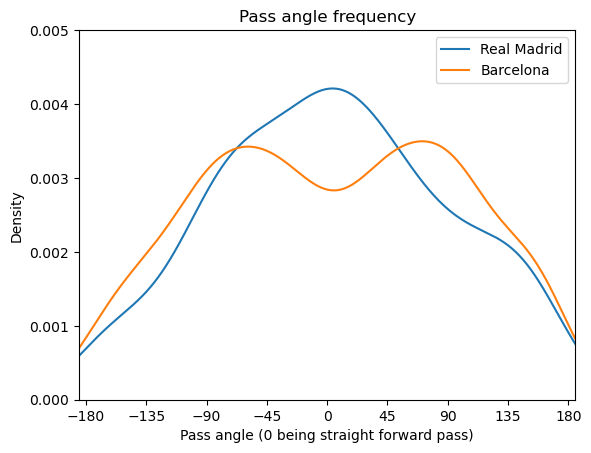

In [39]:
ax = tmp[tmp.team=="Real Madrid"].angle_m.plot(kind='density')
tmp[tmp.team=="Barcelona"].angle_m.plot(kind='density')
ax.set_xlim(-185,185)
ax.set_ylim(0,0.005)
ax.set_xticks(np.arange(-180,180+1,45))
ax.set_title("Pass angle frequency")
ax.set_xlabel("Pass angle (0 being straight forward pass)")
ax.legend(['Real Madrid','Barcelona'])

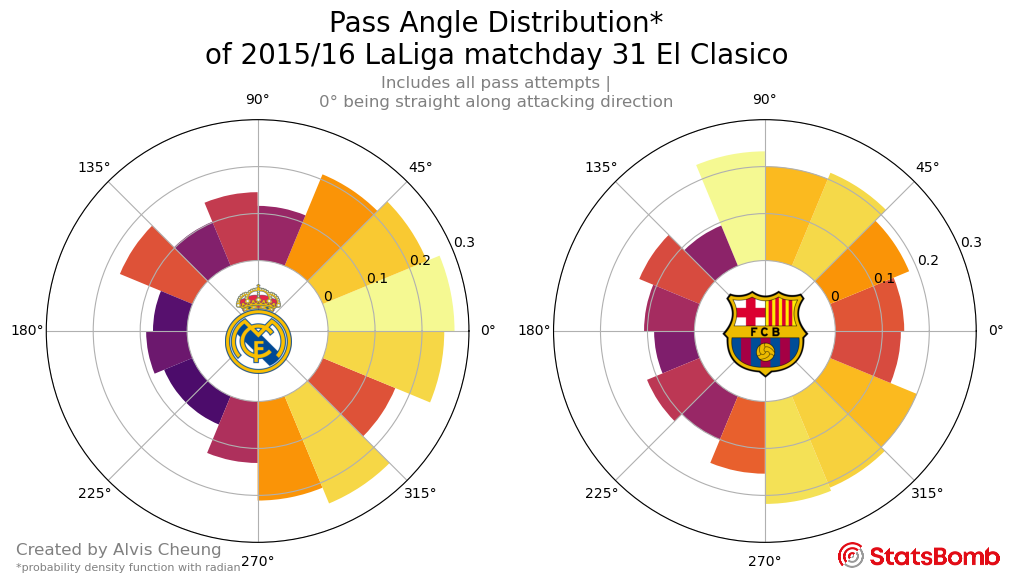

In [40]:
# create bins from -180 to 180
n_bin = np.linspace(-np.pi,np.pi,17)

# polar density plot 
fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121, projection='polar')
ax2 = plt.subplot(122, projection='polar')
N1, bins1, patches1 = ax1.hist(tmp[tmp.team=="Real Madrid"].angle_m/180*np.pi, density=True, bins=n_bin, bottom=0.15)
N2, bins2, patches2 = ax2.hist(tmp[tmp.team=="Barcelona"].angle_m/180*np.pi, density=True, bins=n_bin, bottom=0.15)

# standardize values across the 2 density (for colouring)
max = np.concatenate((N1,N2)).max()
N1c = N1/N1.max()
N2c = N2/N2.max()

# set colours
for n, patch in zip(N1c-0.02, patches1):
    patch.set_facecolor(plt.cm.inferno(n))
for n, patch in zip(N2c-0.02, patches2):
    patch.set_facecolor(plt.cm.inferno(n))

# text
plt.suptitle("Pass Angle Distribution*\nof 2015/16 LaLiga matchday 31 El Clasico", fontsize=20, va='center',ha='center')
fig.text(0.5,0.92,'Includes all pass attempts |\n0° being straight along attacking direction',
            va='top', ha='center', c='grey', fontsize=12)
fig.text(0.1,0.1,'*probability density function with radian',
            va='center', ha='left', c='grey', fontsize=8)
fig.text(0.1,0.13, 'Created by Alvis Cheung',
            va='center', ha='left', c='grey', fontsize=12)

# chart formating
ax1.set_ylim(0,0.4)
ax2.set_ylim(0,0.4)
ax1.set_yticks(np.arange(0.15,0.45,0.1))
ax2.set_yticks(np.arange(0.15,0.45,0.1))
ax1.set_yticklabels(['0','0.1','0.2','0.3'])
ax2.set_yticklabels(['0','0.1','0.2','0.3'])

# logo
ax_madrid_logo = add_image(madrid_logo, fig,
                            left=0.274,
                            bottom=0.423,
                            height=0.15)
ax_barca_logo = add_image(barca_logo, fig,
                            left=0.687,
                            bottom=0.415,
                            height=0.15)
ax_sb_logo = add_image(sb_logo, fig,
                       left=0.785,
                       bottom=0.1,
                       height=0.043)

plt.show()

# plot passing network

source: https://www.nature.com/articles/s41598-019-49969-2, https://soccermatics.readthedocs.io/en/latest/gallery/lesson1/plot_PassNetworks.html

In [41]:
dfMatch[dfMatch.type=='Substitution'].iloc[0].minute

73

In [42]:
# list of players played, before the first subtitution
fcbPlayer = list(set(dfPass.loc[ (dfPass['index'] < dfMatch[dfMatch.type=='Substitution'].iloc[0]['index']) & (dfPass.team=='Barcelona') ].player))
fcbPlayer

['Daniel Alves da Silva',
 'Javier Alejandro Mascherano',
 'Lionel Andrés Messi Cuccittini',
 'Ivan Rakitić',
 'Claudio Andrés Bravo Muñoz',
 'Sergio Busquets i Burgos',
 'Neymar da Silva Santos Junior',
 'Andrés Iniesta Luján',
 'Jordi Alba Ramos',
 'Luis Alberto Suárez Díaz',
 'Gerard Piqué Bernabéu']

In [43]:
def get_upper(string):
    return ''.join(x for x in string if x.isupper())
def pos_abbr(position):
    upper = get_upper(position)
    return upper if upper != "G" else "GK"

In [44]:
fcbPlayerP = []
for i,p in enumerate(fcbPlayer):
    pos = pos_abbr( dfLineupBarca[dfLineupBarca.player_name==p].positions.iloc[0][0]['position'] )
    fcbPlayerP.append(pos)
fcbPlayerP

['RB', 'LCB', 'CF', 'RCM', 'GK', 'CDM', 'LW', 'LCM', 'LB', 'RW', 'RCB']

In [45]:
# short name of the players
fcbPlayerS = []
for i,p in enumerate(fcbPlayer):
    tmp = dfLineupBarca[dfLineupBarca.player_name==p].player_nickname.iloc[0]
    if tmp != None: fcbPlayerS.append(tmp)
    else: fcbPlayerS.append(fcbPlayer[i])
fcbPlayerS

['Dani Alves',
 'Javier Mascherano',
 'Lionel Messi',
 'Ivan Rakitić',
 'Claudio Bravo',
 'Sergio Busquets',
 'Neymar',
 'Andrés Iniesta',
 'Jordi Alba',
 'Luis Suárez',
 'Gerard Piqué']

In [46]:
# number & avg position of pass attempts for each player
fcbPassPos = []
for p in fcbPlayer:
    fcbPassPos.append(
        [np.mean([x[0] for x in dfPass[dfPass.player==p]['location']]), # x
         np.mean([x[1] for x in dfPass[dfPass.player==p]['location']]), # y
         len(dfPass[dfPass.player==p]['location'])] # count
        )
    
fcbPassPos

[[64.55873015873017, 68.13015873015873, 63],
 [49.52658227848102, 28.008860759493675, 79],
 [71.67951807228917, 43.48072289156626, 83],
 [69.7061224489796, 57.78979591836735, 49],
 [15.225, 37.824999999999996, 24],
 [60.28241758241757, 38.54725274725275, 91],
 [86.31627906976745, 26.916279069767445, 43],
 [69.05301204819277, 26.5578313253012, 83],
 [61.811249999999994, 12.36, 80],
 [81.57692307692308, 44.68076923076923, 26],
 [46.95487804878049, 50.36463414634146, 82]]

In [47]:
Counter(dfPass.outcome)

Counter({None: 924,
         'Incomplete': 114,
         'Out': 10,
         'Unknown': 8,
         'Pass Offside': 6})

In [48]:
# count all passing pairs
fcbPassPair = dfPass.loc[ (dfPass['index'] < dfMatch[dfMatch.type=='Substitution'].iloc[0]['index']) & (dfPass.team=='Barcelona') ]\
            [['player','recipient','id']].groupby(['player','recipient']).count().reset_index()
fcbPassPair.head()

,player,recipient,id
0,Andrés Iniesta Luján,Daniel Alves da Silva,3
1,Andrés Iniesta Luján,Gerard Piqué Bernabéu,4
2,Andrés Iniesta Luján,Ivan Rakitić,4
3,Andrés Iniesta Luján,Javier Alejandro Mascherano,2
4,Andrés Iniesta Luján,Jordi Alba Ramos,14


In [49]:
fcbPassPair[fcbPassPair.player=='Ivan Rakitić']

,player,recipient,id
35,Ivan Rakitić,Daniel Alves da Silva,18
36,Ivan Rakitić,Gerard Piqué Bernabéu,10
37,Ivan Rakitić,Javier Alejandro Mascherano,3
38,Ivan Rakitić,Lionel Andrés Messi Cuccittini,7
39,Ivan Rakitić,Luis Alberto Suárez Díaz,2
40,Ivan Rakitić,Neymar da Silva Santos Junior,2
41,Ivan Rakitić,Sergio Busquets i Burgos,6


In [50]:
fcbPassPos[fcbPlayer.index('Andrés Iniesta Luján')]

[69.05301204819277, 26.5578313253012, 83]

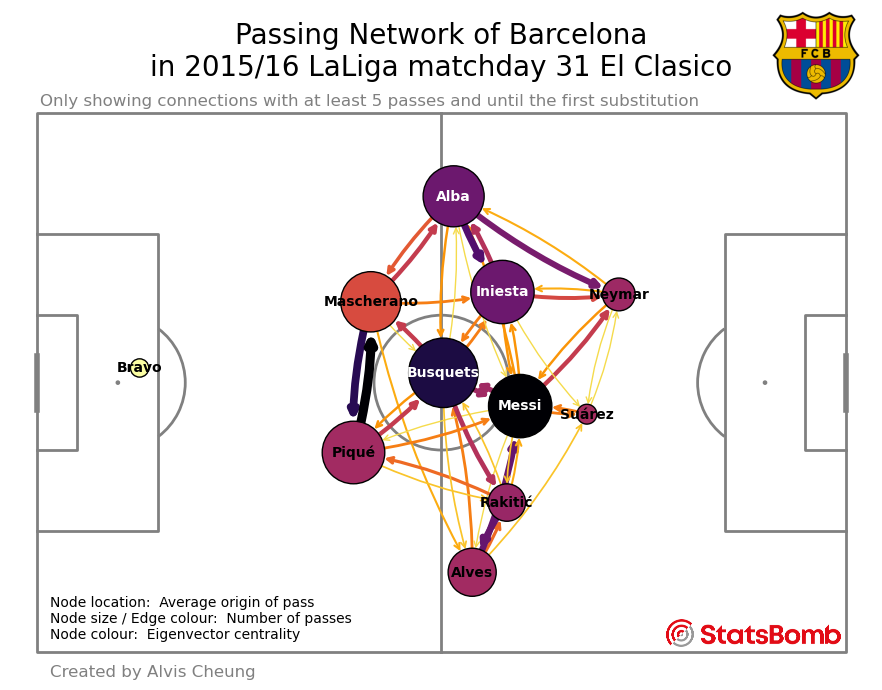

In [51]:
#drawing pitch
pitch = Pitch(line_color = "grey",
              #pitch_color='lightgrey',
              pitch_type='statsbomb')
fig, ax = pitch.draw(figsize=(15,7))

# create network graph
G=nx.DiGraph()

# threshold number of passes to be shown
threshold = 5

# add nodes
for i,cord in enumerate(fcbPassPos):
    x = cord[0]
    y = cord[1]
    #s = cord[2]
    s = (cord[2]/np.max([x[2] for x in fcbPassPos])*50)**2
    G.add_node(fcbPlayer[i],pos=(x,y),size=s)

# add edges
for i,line in fcbPassPair[fcbPassPair.id>=threshold].iterrows():
    G.add_edge(line.player, line.recipient, weight=line.id)


c = ['white' if x>=0.3 else 'black' for x in eigenvector_centrality(G).values()] # label color

# add labels
for i,cord in enumerate(zip(fcbPassPos,c)):
    x = cord[0][0]
    y = cord[0][1]
    plt.annotate(fcbPlayerS[i].split()[-1], (x,y), ha='center', va='center', color=cord[1], weight='bold')

# get node & edge attributes for plotting
pos = nx.get_node_attributes(G,'pos') # node position
size = nx.get_node_attributes(G,'size') # node size
w = list(nx.get_edge_attributes(G,'weight').values()) # edge width
w0 = (np.array(w)-threshold) / (np.max(w)-threshold) # edge color

# plot
nx.draw_networkx(G, pos,
                 # nodes (players)
                 node_color = list(eigenvector_centrality(G).values()),
                 edgecolors = 'black',
                 cmap = plt.cm.inferno_r,
                 #vmin = 0,
                 node_size = list(size.values()),
                 linewidths = 1,
                 #alpha = 0.5,
                 
                 # edges (passes)
                 edge_color = w0,
                 edge_cmap = plt.cm.inferno_r,
                 edge_vmax = 1,
                 edge_vmin = -0.1,
                 width = ( np.array(w)/5 )**1.2,
                 arrowstyle = '->',
                 connectionstyle = 'arc3, rad = 0.08',

                 # labels (player name)
                 labels = {x:'' for x,y in zip(fcbPlayer, fcbPlayerS)},
                 #font_weight = 'bold'
)

'''
# colour legend
plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=threshold, vmax=max(w)),
                                   cmap=plt.cm.inferno_r),
             pad = -0.07,
             shrink = 0.85,
             ax = plt.gca(),
             label = 'Number of passes')
plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=1),
                                   cmap=plt.cm.inferno_r),
             pad = 0,
             shrink = 0.85,
             ax = plt.gca(),
             label = 'Eigenvector centrality')
'''

# texts
plt.text(2, 78,
         "Node location:  Average origin of pass\n\
Node size / Edge colour:  Number of passes\n\
Node colour:  Eigenvector centrality",
         size='10')
plt.suptitle("Passing Network of Barcelona\nin 2015/16 LaLiga matchday 31 El Clasico", size=20, y=0.92,x=0.5, va='center',ha='center')
plt.title('Only showing connections with at least '+str(threshold)+' passes and until the first substitution',loc='left',fontsize=12,color='grey',x=0.035,y=0.96,va='center',ha='left')
plt.text(2,83, 'Created by Alvis Cheung',
            va='center', ha='left', c='grey', fontsize=12)

# logo
ax_team_logo = add_image(barca_logo, fig,
                          left=0.72,
                          bottom=0.85,
                          height=0.13)
ax_sb_logo = add_image(sb_logo, fig,
                       left=0.65,
                       bottom=0.07,
                       height=0.04)

plt.show()

We can see that even though Messi and Busquets were the key passers and centroid of the passing network, all other players were heavily involved in the passing network, that most of them had at least 5 passes to their neighbouring teammates.

Even though Messi was a RW on paper, he dropped deep to orcheestrate attacking plays, played as a CAM with the support of the CDM and CMs.

We can see a typical Barca attacking play: the full backs connecting with the wingers (Alba to Neymar, Alves to Messi).

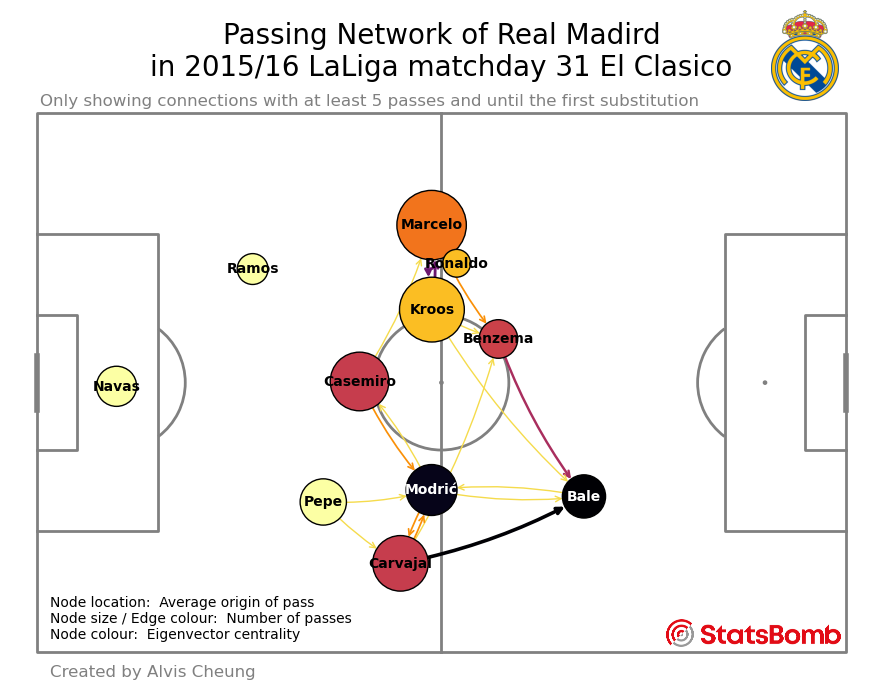

In [52]:
fcbPlayer = list(set(dfPass.loc[ (dfPass['index'] < dfMatch[dfMatch.type=='Substitution'].iloc[0]['index']) & (dfPass.team=='Real Madrid') ].player))

# short name of the players
fcbPlayerS = []
for i,p in enumerate(fcbPlayer):
    tmp = pd.DataFrame(dfLineup.iloc[0].lineup)[pd.DataFrame(dfLineup.iloc[0].lineup).player_name==p].player_nickname.iloc[0]
    if tmp != None: fcbPlayerS.append(tmp)
    else: fcbPlayerS.append(fcbPlayer[i])

# number & avg position of pass attempts for each player
fcbPassPos = []
for p in fcbPlayer:
    fcbPassPos.append(
        [np.mean([x[0] for x in dfPass[dfPass.player==p]['location']]), # x
         np.mean([x[1] for x in dfPass[dfPass.player==p]['location']]), # y
         len(dfPass[dfPass.player==p]['location'])] # count
        )

# count passing pairs
fcbPassPair = dfPass.loc[ (dfPass['index'] < dfMatch[dfMatch.type=='Substitution'].iloc[0]['index']) & (dfPass.team=='Real Madrid') ]\
            [['player','recipient','id']].groupby(['player','recipient']).count().reset_index()

#### plot passing network ########
#drawing pitch
pitch = Pitch(line_color = "grey",
              #pitch_color='lightgrey',
              pitch_type='statsbomb')
fig, ax = pitch.draw(figsize=(15,7))

# create network graph
G=nx.DiGraph()

# threshold number of passes to be shown
threshold = 5

# add nodes
for i,cord in enumerate(fcbPassPos):
    x = cord[0]
    y = cord[1]
    #s = cord[2]
    s = (cord[2]/np.max([x[2] for x in fcbPassPos])*50)**2
    G.add_node(fcbPlayer[i],pos=(x,y),size=s)

# add edges
for i,line in fcbPassPair[fcbPassPair.id>=threshold].iterrows():
    G.add_edge(line.player, line.recipient, weight=line.id)


c = ['white' if x>=0.3 else 'black' for x in eigenvector_centrality(G).values()] # label color

# add labels
for i,cord in enumerate(zip(fcbPassPos,c)):
    x = cord[0][0]
    y = cord[0][1]
    plt.annotate(fcbPlayerS[i].split()[-1], (x,y), ha='center', va='center', color=cord[1], weight='bold')

# get node & edge attributes for plotting
pos = nx.get_node_attributes(G,'pos') # node position
size = nx.get_node_attributes(G,'size') # node size
w = list(nx.get_edge_attributes(G,'weight').values()) # edge width
w0 = (np.array(w)-threshold) / (np.max(w)-threshold) # edge color

# plot
nx.draw_networkx(G, pos,
                 # nodes (players)
                 node_color = list(eigenvector_centrality(G).values()),
                 edgecolors = 'black',
                 cmap = plt.cm.inferno_r,
                 #vmin = 0,
                 node_size = list(size.values()),
                 linewidths = 1,
                 #alpha = 0.5,
                 
                 # edges (passes)
                 edge_color = w0,
                 edge_cmap = plt.cm.inferno_r,
                 edge_vmax = 1,
                 edge_vmin = -0.1,
                 width = ( np.array(w)/5 )**1.2,
                 arrowstyle = '->',
                 connectionstyle = 'arc3, rad = 0.08',

                 # labels (player name)
                 labels = {x:'' for x,y in zip(fcbPlayer, fcbPlayerS)},
                 #font_weight = 'bold'
)

# texts
plt.text(2, 78,
         "Node location:  Average origin of pass\n\
Node size / Edge colour:  Number of passes\n\
Node colour:  Eigenvector centrality",
         size='10')
plt.suptitle("Passing Network of Real Madird\nin 2015/16 LaLiga matchday 31 El Clasico", size=20, y=0.92,x=0.5, va='center',ha='center')
plt.title('Only showing connections with at least '+str(threshold)+' passes and until the first substitution',loc='left',fontsize=12,color='grey',x=0.035,y=0.96,va='center',ha='left')
plt.text(2,83, 'Created by Alvis Cheung',
            va='center', ha='left', c='grey', fontsize=12)

# logo
ax_team_logo = add_image(madrid_logo, fig,
                          left=0.72,
                          bottom=0.85,
                          height=0.13)
ax_sb_logo = add_image(sb_logo, fig,
                       left=0.65,
                       bottom=0.07,
                       height=0.04)

plt.show()

A clear difference from Barca's network, Los Blancos' played with far less passes, not many of them made more than 5 passes with their neighbouring teammates.

Even though Modric was the centroid of the network, he wasn't the direct outlet of attacks. Bale was the target man of attacks, with Carvajal and Benzema made the most passes to him, while being the furthest on the pitch.

Also, we can see that Real Madrid's each flank played on their own: Modric, Carvajal and Bale connected well on the right, while Kroos, Marcelo, Ronaldo and Benzema connected on the left.

Comparing with Barca's defence pushing high and heavily involving in the play, Real Madrid's defence kept low and were much quieter.